# Setting folder

In [1]:
%pwd

'/workspace/source'

# Import

In [2]:
import os
import time

from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# import albumentations as A
# import albumentations.pytorch as Ap

from torchvision import transforms
import torchvision.models as models

from utils import load_all_set

## seed value

In [3]:
IN_HEIGHT, IN_WIDTH = 224, 224

RESOURCE = "GPU"

RANDOM_SEED = 46

EPOCH = 100
BATCH_SIZE =  64
lr = 1e-3
EARLY_STOP = 10

model_path = 'result/resnet50/resnet50.pth'

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

if RESOURCE == "CPU":
    device = torch.device("cpu")
    torch.manual_seed(RANDOM_SEED)
elif RESOURCE == "GPU":
    device = torch.device("cuda")
    torch.cuda.manual_seed(RANDOM_SEED)

# Install dataset

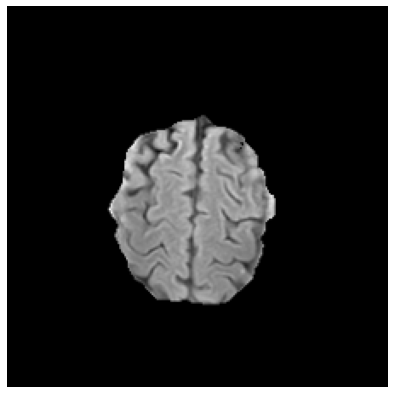

In [4]:
x_train, y_train, x_val, y_val, x_test, y_test = load_all_set()

plt.figure(figsize=(7,7))
plt.axis('off')
plt.imshow(x_train[0], cmap='gray')

In [5]:
class MyDataset(Dataset):
    def __init__(self, xs, ys, transforms=None):
        self.xs = xs
        self.ys = ys
        self.transforms = transforms
        self.data_num = len(xs)

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]

        if self.transforms:
            x = self.transforms(x)
        
        return x, y

In [6]:
transforms_train = transforms.Compose([
    transforms.ToTensor(),
])

transforms_val = transforms.Compose([
    transforms.ToTensor(),
])

In [7]:
dataset_train = MyDataset(xs=x_train, ys=y_train, transforms=transforms_train)
dataset_val = MyDataset(xs=x_val, ys=y_val, transforms=transforms_val)

train_n = len(dataset_train)
val_n = len(dataset_val)

print(train_n)
print(val_n)

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)

8980
1448


# Model compile

In [8]:
model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(nn.Linear(2048,1, bias=True),  nn.Sigmoid())
model = model.to(device)

criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=lr)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Train

  0%|          | 0/141 [00:00<?, ?it/s]

epoch:1/100 [train]loss3.781358 acc:0.6061, [val]loss:4.061235, acc:0.6145


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:2/100 [train]loss0.126659 acc:0.9649, [val]loss:0.146839, acc:0.9543


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:3/100 [train]loss0.165680 acc:0.9429, [val]loss:0.267101, acc:0.9118


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:4/100 [train]loss0.193872 acc:0.9265, [val]loss:0.296513, acc:0.8747


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:5/100 [train]loss0.133532 acc:0.9547, [val]loss:0.273724, acc:0.8889


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:6/100 [train]loss0.083061 acc:0.9747, [val]loss:0.191463, acc:0.9321


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:7/100 [train]loss0.179626 acc:0.9277, [val]loss:0.389374, acc:0.8556


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:8/100 [train]loss0.100553 acc:0.9668, [val]loss:0.302922, acc:0.8940


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:9/100 [train]loss0.098190 acc:0.9677, [val]loss:0.276944, acc:0.9213


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:10/100 [train]loss0.060501 acc:0.9798, [val]loss:0.171418, acc:0.9420


<Figure size 504x720 with 0 Axes>

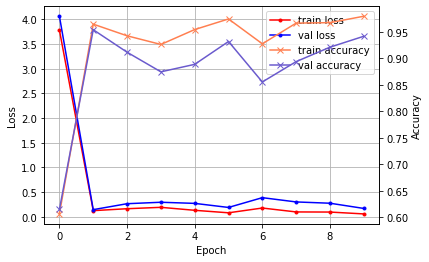

  0%|          | 0/141 [00:00<?, ?it/s]

epoch:11/100 [train]loss0.058787 acc:0.9804, [val]loss:0.136507, acc:0.9632


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:12/100 [train]loss0.047643 acc:0.9828, [val]loss:0.201629, acc:0.9147


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:13/100 [train]loss0.078670 acc:0.9763, [val]loss:0.258564, acc:0.9101


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:14/100 [train]loss0.074157 acc:0.9726, [val]loss:0.297363, acc:0.8980


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:15/100 [train]loss0.031380 acc:0.9873, [val]loss:0.183705, acc:0.9363


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:16/100 [train]loss0.052426 acc:0.9830, [val]loss:0.156385, acc:0.9507


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:17/100 [train]loss0.048934 acc:0.9834, [val]loss:0.207783, acc:0.9382


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:18/100 [train]loss0.062736 acc:0.9795, [val]loss:0.376603, acc:0.9128


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:19/100 [train]loss0.289848 acc:0.9093, [val]loss:0.702898, acc:0.8264


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:20/100 [train]loss0.045763 acc:0.9857, [val]loss:0.342413, acc:0.9084


<Figure size 504x720 with 0 Axes>

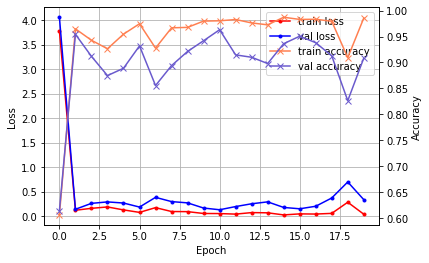

  0%|          | 0/141 [00:00<?, ?it/s]

epoch:21/100 [train]loss0.071926 acc:0.9744, [val]loss:0.421062, acc:0.8865


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:22/100 [train]loss0.028171 acc:0.9921, [val]loss:0.279974, acc:0.9133


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:23/100 [train]loss0.027160 acc:0.9924, [val]loss:0.230555, acc:0.9221


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:24/100 [train]loss0.043513 acc:0.9847, [val]loss:0.267363, acc:0.9285


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:25/100 [train]loss0.030576 acc:0.9912, [val]loss:0.207271, acc:0.9221


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:26/100 [train]loss0.039497 acc:0.9875, [val]loss:0.412455, acc:0.8993


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:27/100 [train]loss0.025739 acc:0.9906, [val]loss:0.273997, acc:0.9223


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:28/100 [train]loss0.026575 acc:0.9931, [val]loss:0.256336, acc:0.9292


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:29/100 [train]loss0.017589 acc:0.9951, [val]loss:0.158697, acc:0.9564


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:30/100 [train]loss0.891907 acc:0.8216, [val]loss:3.456728, acc:0.7550


<Figure size 504x720 with 0 Axes>

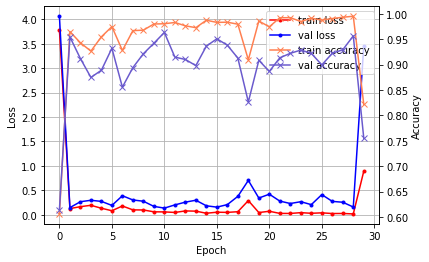

  0%|          | 0/141 [00:00<?, ?it/s]

epoch:31/100 [train]loss0.017407 acc:0.9952, [val]loss:0.194959, acc:0.9386


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:32/100 [train]loss0.009642 acc:0.9972, [val]loss:0.221808, acc:0.9353


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:33/100 [train]loss0.011818 acc:0.9961, [val]loss:0.184929, acc:0.9545


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:34/100 [train]loss0.022747 acc:0.9925, [val]loss:0.270986, acc:0.9164


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:35/100 [train]loss0.034699 acc:0.9908, [val]loss:0.260835, acc:0.9046


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:36/100 [train]loss0.015365 acc:0.9960, [val]loss:0.311073, acc:0.9351


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:37/100 [train]loss0.041856 acc:0.9867, [val]loss:0.396605, acc:0.9200


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:38/100 [train]loss0.007007 acc:0.9979, [val]loss:0.306127, acc:0.9186


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:39/100 [train]loss0.047520 acc:0.9948, [val]loss:0.566028, acc:0.9065


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:40/100 [train]loss0.018140 acc:0.9945, [val]loss:0.247912, acc:0.9170


<Figure size 504x720 with 0 Axes>

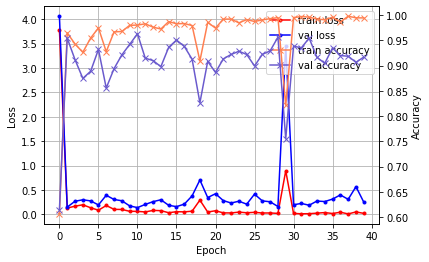

  0%|          | 0/141 [00:00<?, ?it/s]

epoch:41/100 [train]loss0.011087 acc:0.9977, [val]loss:0.208468, acc:0.9346


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:42/100 [train]loss0.045777 acc:0.9849, [val]loss:0.392342, acc:0.9098


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:43/100 [train]loss0.008452 acc:0.9981, [val]loss:0.256922, acc:0.9351


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:44/100 [train]loss0.006398 acc:0.9983, [val]loss:0.279140, acc:0.9197


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:45/100 [train]loss0.016695 acc:0.9950, [val]loss:0.367071, acc:0.9319


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:46/100 [train]loss0.013615 acc:0.9962, [val]loss:0.336330, acc:0.9202


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:47/100 [train]loss0.060343 acc:0.9797, [val]loss:0.342184, acc:0.9173


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:48/100 [train]loss0.024365 acc:0.9936, [val]loss:0.359861, acc:0.9231


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:49/100 [train]loss0.026078 acc:0.9899, [val]loss:0.349660, acc:0.9019


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:50/100 [train]loss0.004908 acc:0.9988, [val]loss:0.309649, acc:0.9208


<Figure size 504x720 with 0 Axes>

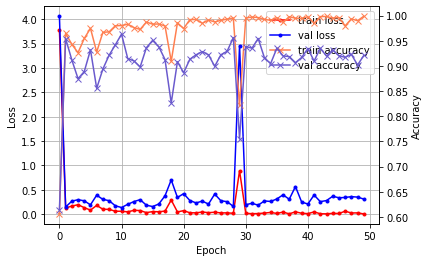

  0%|          | 0/141 [00:00<?, ?it/s]

epoch:51/100 [train]loss0.020302 acc:0.9938, [val]loss:0.376638, acc:0.9107


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:52/100 [train]loss0.000938 acc:0.9997, [val]loss:0.278954, acc:0.9370


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:53/100 [train]loss0.013734 acc:0.9990, [val]loss:0.394564, acc:0.9276


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:54/100 [train]loss0.005689 acc:0.9988, [val]loss:0.459839, acc:0.9341


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:55/100 [train]loss0.033225 acc:0.9893, [val]loss:0.246753, acc:0.9181


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:56/100 [train]loss0.010256 acc:0.9971, [val]loss:0.348082, acc:0.9065


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:57/100 [train]loss0.035080 acc:0.9884, [val]loss:0.329827, acc:0.9264


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:58/100 [train]loss0.098128 acc:0.9635, [val]loss:0.648911, acc:0.8679


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:59/100 [train]loss0.042500 acc:0.9834, [val]loss:0.634725, acc:0.8838


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:60/100 [train]loss0.015118 acc:0.9961, [val]loss:0.347870, acc:0.9264


<Figure size 504x720 with 0 Axes>

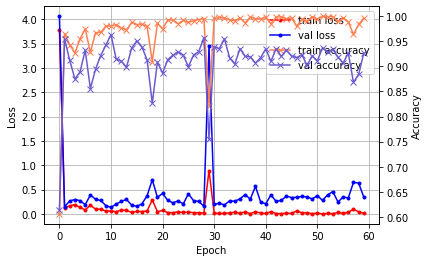

  0%|          | 0/141 [00:00<?, ?it/s]

epoch:61/100 [train]loss0.004110 acc:0.9991, [val]loss:0.356286, acc:0.9208


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:62/100 [train]loss0.008753 acc:0.9987, [val]loss:0.260303, acc:0.9303


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:63/100 [train]loss0.001699 acc:0.9994, [val]loss:0.322841, acc:0.9363


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:64/100 [train]loss0.001104 acc:0.9997, [val]loss:0.383606, acc:0.9401


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:65/100 [train]loss0.012284 acc:0.9961, [val]loss:0.434652, acc:0.9162


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:66/100 [train]loss0.109043 acc:0.9639, [val]loss:0.389002, acc:0.8989


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:67/100 [train]loss0.454184 acc:0.8787, [val]loss:0.911183, acc:0.8088


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:68/100 [train]loss0.015415 acc:0.9946, [val]loss:0.491516, acc:0.9139


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:69/100 [train]loss0.011688 acc:0.9970, [val]loss:0.571590, acc:0.9197


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:70/100 [train]loss0.003576 acc:0.9996, [val]loss:0.445934, acc:0.9333


<Figure size 504x720 with 0 Axes>

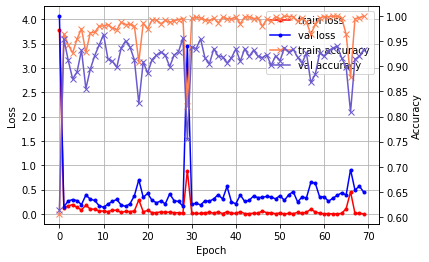

  0%|          | 0/141 [00:00<?, ?it/s]

epoch:71/100 [train]loss0.006291 acc:0.9983, [val]loss:0.507683, acc:0.9302


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:72/100 [train]loss0.003784 acc:0.9993, [val]loss:0.320927, acc:0.9359


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:73/100 [train]loss0.003073 acc:0.9996, [val]loss:0.428497, acc:0.9137


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:74/100 [train]loss0.001237 acc:0.9997, [val]loss:0.340559, acc:0.9285


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:75/100 [train]loss0.018867 acc:0.9957, [val]loss:0.488639, acc:0.8971


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:76/100 [train]loss0.018125 acc:0.9941, [val]loss:0.399878, acc:0.9285


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:77/100 [train]loss0.009764 acc:0.9976, [val]loss:0.322792, acc:0.9270


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:78/100 [train]loss0.009244 acc:0.9977, [val]loss:0.451228, acc:0.9216


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:79/100 [train]loss0.013526 acc:0.9956, [val]loss:0.556812, acc:0.9213


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:80/100 [train]loss0.008952 acc:0.9982, [val]loss:0.530998, acc:0.9310


<Figure size 504x720 with 0 Axes>

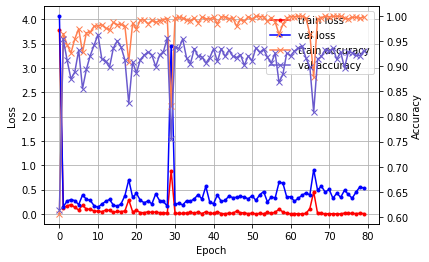

  0%|          | 0/141 [00:00<?, ?it/s]

epoch:81/100 [train]loss0.005374 acc:0.9990, [val]loss:0.250498, acc:0.9284


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:82/100 [train]loss0.002034 acc:0.9993, [val]loss:0.364923, acc:0.9302


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:83/100 [train]loss0.001965 acc:0.9997, [val]loss:0.329993, acc:0.9258


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:84/100 [train]loss0.001768 acc:0.9996, [val]loss:0.524524, acc:0.9205


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:85/100 [train]loss0.003375 acc:0.9991, [val]loss:0.446736, acc:0.9056


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:86/100 [train]loss0.000378 acc:1.0000, [val]loss:0.435464, acc:0.9279


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:87/100 [train]loss0.000058 acc:1.0000, [val]loss:0.457019, acc:0.9274


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:88/100 [train]loss0.000028 acc:1.0000, [val]loss:0.473124, acc:0.9245


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:89/100 [train]loss0.000020 acc:1.0000, [val]loss:0.470475, acc:0.9281


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:90/100 [train]loss0.000013 acc:1.0000, [val]loss:0.482718, acc:0.9243


<Figure size 504x720 with 0 Axes>

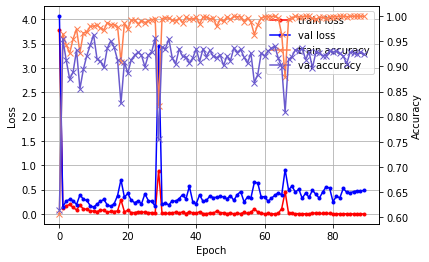

  0%|          | 0/141 [00:00<?, ?it/s]

epoch:91/100 [train]loss0.000009 acc:1.0000, [val]loss:0.497086, acc:0.9265


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:92/100 [train]loss0.000009 acc:1.0000, [val]loss:0.488965, acc:0.9276


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:93/100 [train]loss0.000006 acc:1.0000, [val]loss:0.498586, acc:0.9279


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:94/100 [train]loss0.000005 acc:1.0000, [val]loss:0.502385, acc:0.9240


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:95/100 [train]loss0.000004 acc:1.0000, [val]loss:0.516589, acc:0.9255


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:96/100 [train]loss0.000004 acc:1.0000, [val]loss:0.507827, acc:0.9288


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:97/100 [train]loss0.000002 acc:1.0000, [val]loss:0.535924, acc:0.9254


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:98/100 [train]loss0.000003 acc:1.0000, [val]loss:0.580258, acc:0.9273


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:99/100 [train]loss0.000003 acc:1.0000, [val]loss:0.695679, acc:0.9285


  0%|          | 0/141 [00:00<?, ?it/s]

epoch:100/100 [train]loss0.000003 acc:1.0000, [val]loss:0.661227, acc:0.9253


<Figure size 504x720 with 0 Axes>

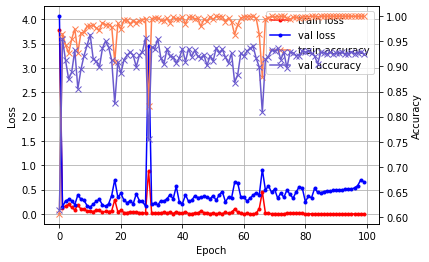

<Figure size 504x720 with 0 Axes>

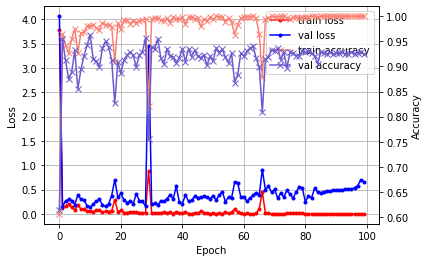

<Figure size 432x288 with 0 Axes>

In [9]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

min_val_loss = val_n
stop_count = 0

for epoch in range(EPOCH):
    model.train()

    tr_loss = 0
    correct = 0
    total = 0

    # Training
    train_time_start = time.time()

    step = 0
    batch_accuracy = 0
    for inputs, targets in tqdm(dataloader_train):
        optimizer.zero_grad()

        n_batch = len(inputs)

        inputs = inputs.to(device)
        targets = targets.to(torch.float32)
        targets = targets.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, targets)

        loss = loss / n_batch
        loss.backward()

        optimizer.step()
        
        b_outputs = outputs.squeeze().cpu().detach().numpy().copy()
        b_targets = targets.squeeze().cpu().detach().numpy().copy()
        b_outputs = np.where(b_outputs>0.5, 1.0, 0.0)
        batch_accuracy += accuracy_score(b_targets, b_outputs)
        step += 1

    train_time_end = time.time()

    model.eval()

    # train data accuracy and loss 
    step = 0
    batch_accuracy = 0
    train_loss = 0
    with torch.no_grad():
        for train_inputs, train_targets in dataloader_train:
            
            train_inputs = train_inputs.to(device)
            train_targets = train_targets.to(torch.float32)
            train_targets = train_targets.to(device)
            
            train_outputs = model(train_inputs)

            loss = criterion(train_outputs, train_targets)

            train_loss += loss.item() / train_n

            b_outputs = train_outputs.squeeze().cpu().numpy().copy()
            b_targets = train_targets.squeeze().cpu().numpy().copy()
            b_outputs = np.where(b_outputs>0.5, 1.0, 0.0)
            batch_accuracy += accuracy_score(b_targets, b_outputs)
            step += 1

    train_accuracy = batch_accuracy / step
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    # Validation data accuracy and loss
    val_time_start = time.time()

    step = 0
    batch_accuracy = 0
    val_loss = 0
    with torch.no_grad():
        for val_inputs, val_targets in dataloader_val:
            
            val_inputs = val_inputs.to(device)
            val_targets = val_targets.to(torch.float32)
            val_targets = val_targets.to(device)
            
            val_outputs = model(val_inputs)

            loss = criterion(val_outputs, val_targets)

            val_loss += loss.item() / val_n

            b_outputs = val_outputs.squeeze().cpu().numpy().copy()
            b_targets = val_targets.squeeze().cpu().numpy().copy()
            b_outputs = np.where(b_outputs>0.5, 1.0, 0.0)
            batch_accuracy += accuracy_score(b_targets, b_outputs)
            step += 1

    val_accuracy = batch_accuracy / step
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)

    val_time_end = time.time()

    if min_val_loss > val_loss:
        torch.save(model.state_dict(), model_path)
        stop_count = 0
    
    if not min_val_loss > val_loss:
        stop_count += 1
    
    if stop_count == EARLY_STOP:
        print('Early Stopping!!')
        print(f"epoch:{epoch+1}/{EPOCH} [train]loss{train_loss:.6f} acc:{train_accuracy:.4f}, [val]loss:{val_loss:.6f}, acc:{val_accuracy:.4f}")
        break
    
    train_time = train_time_end - train_time_start
    val_time = val_time_end - val_time_start
    total_time = train_time + val_time

    print(f"epoch:{epoch+1}/{EPOCH} [train]loss{train_loss:.6f} acc:{train_accuracy:.4f}, [val]loss:{val_loss:.6f}, acc:{val_accuracy:.4f}")

    if (epoch+1) % 10 == 0:
        plt.figure(figsize=(7,10))
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.grid()
        ax1.plot(train_losses, marker=".", markersize=6, color="red", label="train loss")
        ax1.plot(val_losses, marker=".", markersize=6, color="blue", label="val loss")
        ax2.plot(train_accuracies, marker="x", markersize=6, color="coral", label="train accuracy")
        ax2.plot(val_accuracies, marker="x", markersize=6, color="slateblue", label="val accuracy")
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc="upper right")
        ax1.set(xlabel="Epoch", ylabel="Loss")
        ax2.set(ylabel="Accuracy")
        plt.show()

    if (epoch +1)== EPOCH:
        plt.figure(figsize=(7,10))
        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        ax1.grid()
        ax1.plot(train_losses, marker=".", markersize=6, color="red", label="train loss")
        ax1.plot(val_losses, marker=".", markersize=6, color="blue", label="val loss")
        ax2.plot(train_accuracies, marker="x", markersize=6, color="salmon", label="train accuracy")
        ax2.plot(val_accuracies, marker="x", markersize=6, color="slateblue", label="val accuracy")
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc="upper right")
        ax1.set(xlabel="Epoch", ylabel="Loss")
        ax2.set(ylabel="Accuracy")
        plt.show()
        plt.savefig('result/resnet50/acc_loss.png', bbox_inches='tight')

# Test

94.57%


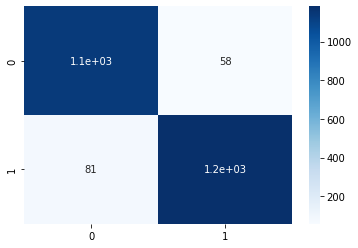

In [10]:
transforms_test = transforms.Compose([
    transforms.ToTensor(),
])
dataset_test = MyDataset(xs=x_test, ys=y_test, transforms=transforms_test)

test_n = len(dataset_test)

dataloader_test = DataLoader(dataset_test, batch_size=2*BATCH_SIZE)

model.load_state_dict(torch.load(model_path))
model.eval()

step = 0
batch_accuracy = 0
y_pred = []
with torch.no_grad():
    for inputs, targets in dataloader_test:
        n_batch = len(inputs)

        inputs = inputs.to(device)
        targets = targets.to(torch.float32)
        targets = targets.to(device)
        
        outputs = model(inputs)
        
        b_outputs = outputs.squeeze().cpu().numpy().copy()
        b_targets = targets.squeeze().cpu().numpy().copy()
        b_outputs = np.where(b_outputs>0.5, 1.0, 0.0)

        for i in b_outputs:
            y_pred.append([i])

        batch_accuracy += accuracy_score(b_targets, b_outputs)
        step += 1

test_accuracy = batch_accuracy / step
y_pred = np.array(y_pred)

print(f'{100*test_accuracy:.2f}%')

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.savefig('result/resnet50/confusion_matrix.png', bbox_inches='tight')